# Introduction and EDA

## Description:
Creates functions to get track and artist features from Spotify's API using Spotipy Package. After getting the required track and artist features, it creates a pandas database with the requested variables. Finally, Exploratory Data Analysis is carried out.

Spotipy Package can be found at: https://spotipy.readthedocs.io



<hr style="height:2pt">

In [70]:
import json # import the json library
%matplotlib inline
import numpy as np
import scipy 
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from pandas.tools.plotting import table
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [5]:
#reading playlist files which are in json format
path = "/Users/yalda/Dropbox/DS Project/01 - Data"
with open(path+"/mpd.slice.0-999.json", "r") as fd:
    plylist = json.load(fd)
    

In [6]:
def feature_list_func(plylist_dic, feature, n_playlist):
    feature_list = []
    length_playlist = np.minimum(n_playlist,len(plylist_dic.get('playlists'))) # the output will be based on the min of the n_playlist and the actual length of the input playlist
    for i in range(length_playlist):
        playlist = plylist_dic.get('playlists')[i]
        for j in range(len(playlist.get('tracks'))):
            feature_list.append(playlist.get('tracks')[j].get(feature))
    return feature_list
            
        

In [7]:
def common_feature_func(plylist_dic, n, feature,n_playlist): 
    # this function will return the n most repeated feature in the play list, for example the n most common artist or ...
    feature_lists= pd.DataFrame(feature_list_func(plylist_dic,feature,n_playlist), columns=[feature]) #creating a list of all feature (artist) of all tracks of the play list
    common_feature = feature_lists.groupby([feature],as_index=False).size().sort_values(ascending=False)[0:n]
    return common_feature.reset_index(drop=False)                        
                               

In [8]:
track_uri = feature_list_func(plylist, feature = 'track_uri', n_playlist = 1000)
artist_uri = feature_list_func(plylist, feature = 'artist_uri', n_playlist = 1000)



## Description of Data

Our data consist of two primary databases which both are from the same source, Spotify. The primary source is the Million Playlist Dataset and our secondary source is data taken from Spotify’s Web API, this latter one is used to compliment the primary source of data.

**Base Dataset: Million Playlist Dataset**
Our base data consists of a set of music playlists obtained from Spotify’s “The Million Playlist Dataset”. The size of this dataset is approximately 5.4 GB, and its general format is the following:


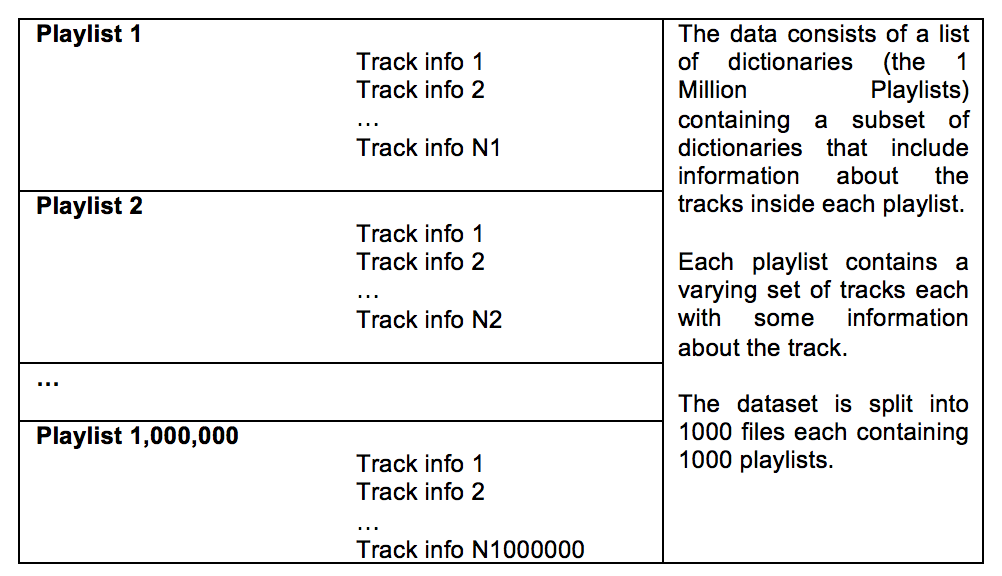

In [29]:
Image("img/eda_table1.png",width=600, height=400)

For EDA purposes, we focused on 1000 playlists in order to get a quick understanding of the structure of the data. A sample of the raw format of the data is as follows:


<img src='img/eda_pic1.png'>

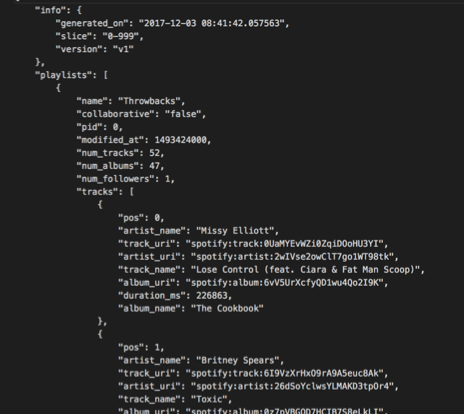

In [32]:
Image("img/eda_pic1.png",width=500, height=400)


From the base dataset, we can extract the following useful track information within any playlist:
1.	Track Name
2.	Artist Name
3.	Album Name
4.	Track URI – Unique Spotify identifier for that particular song
5.	Artist URI – Unique Spotify identifier for that particular artist
6.	Duration_ms – duration of song in milliseconds

This dataset does not contain enough meaningful information about the tracks, but it does contain enough information for us to search additional databases for complementary data. We obtained a unique Spotify song identifier called “track_uri” and a unique Spotify artist identifier called “artist_uri” which we used to obtain additional data from Spotify’s web API.

**Second Dataset: Spotify Web API**
In order to obtain more meaningful and descriptive variables about each of the tracks that we sample, we interfaced with Spotify’s web API where the following information about any song can be obtained:


In [33]:
def create_spotipy_obj():
#    import spotipy
#    from spotipy.oauth2 import SpotifyClientCredentials
#    import spotipy.util as util
    
    """
    Uses dbarjum's client id for DS Project
    """

    SPOTIPY_CLIENT_ID = '54006da9bd7849b7906b944a7fa4e29d'
    SPOTIPY_CLIENT_SECRET = 'f54ae294a30c4a99b2ff330a923cd6e3'
    SPOTIPY_REDIRECT_URI = 'http://localhost/'

    username = 'dbarjum'
    scope = 'user-library-read'
    
    token = util.prompt_for_user_token(username,scope,client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)
    client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, 
                                                          client_secret=SPOTIPY_CLIENT_SECRET, proxies=None)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    return sp

In [35]:
sp = create_spotipy_obj()

In [36]:
def get_all_features(track_list = list, artist_list = list, sp=None):
    
    """
    This function takes in a list of tracks and a list of artists, along
    with a spotipy object and generates two lists of features from Spotify's API.
    
    inputs:
        1. track_list: list of all tracks to be included in dataframe
        2. artist_list: list of all artists corresponding to tracks
        3. sp: spotipy object to communicate with Spotify API
    
    returns:
        1. track_features: list of all features for each track in track_list
        2. artist_features: list of all artist features for each artist in artist_list
    """
    
    track_features = []
    artist_features = []
    
    track_iters = int(len(track_list)/50)
    track_remainders = len(track_list)%50

    start = 0
    end = start+50
    
    for i in range(track_iters):
        track_features.extend(sp.audio_features(track_list[start:end]))
        artist_features.extend(sp.artists(artist_list[start:end]).get('artists'))
        start += 50
        end = start+50
    

    if track_remainders:
        end = start + track_remainders
        track_features.extend(sp.audio_features(track_list[start:end]))
        artist_features.extend(sp.artists(artist_list[start:end]).get('artists'))
    
    
    return track_features, artist_features

In [37]:
start_time = time.time()
t_features, a_features = get_all_features(track_uri, artist_uri, sp)
print("--- %s seconds ---" % (time.time() - start_time))

--- 313.6843388080597 seconds ---


In [44]:
def create_song_df(track_features=list, artist_features=list):
    
    """
    This function takes in two lists of track and artist features, respectively,
    and generates a dataframe of the features.
    
    inputs:
        1. track_features: list of all tracks including features
        2. artist_features: list of all artists including features
    
    returns:
        1. df: a pandas dataframe of size (N, X) where N corresponds to the number of songs
        in track_features, X is the number of features in the dataframe.
    """
    
    import pandas as pd
    
    selected_song_features = ['uri', 'duration_ms', 'time_signature', 'key',
                              'tempo', 'energy', 'mode', 'loudness', 'speechiness', 
                              'danceability', 'acousticness', 'instrumentalness', 
                              'valence', 'liveness']
    selected_artist_features = ['followers', 'uri', 'name', 'popularity', 'genres']
    
    col_names = ['song_uri', 'duration_ms', 'time_signature', 'key',
                 'tempo', 'energy', 'mode', 'loudness', 'speechiness', 
                 'danceability', 'acousticness', 'instrumentalness', 
                 'valence', 'liveness', 'artist_followers', 'artist_uri',
                 'artist_name', 'artist_popularity']
    
    
    data = []

    for i, j in zip(track_features, artist_features):
        temp = []
        for sf in selected_song_features:
            temp.append(i.get(sf))
        for af in selected_artist_features:
            if af == 'followers':
                temp.append(j.get('followers').get('total'))
            elif af == 'genres':
                for g in j.get('genres'):
                    temp.append(g)
            else:
                temp.append(j.get(af))

        data.append(list(temp))
    
    df = pd.DataFrame(data)

    for i in range(len(df.columns)- len(col_names)):
        col_names.append('g'+str(i+1))

    df.columns = col_names
    
    return df

In [45]:
songs_df = create_song_df(t_features, a_features)

songs_df.head()

song_uri  duration_ms  time_signature  key    tempo  energy  mode  loudness  speechiness  danceability  acousticness  instrumentalness  valence  liveness  artist_followers                             artist_uri        artist_name  artist_popularity         g1       g2             g3    g4       g5    g6    g7                g8                  g9   g10   g11   g12   g13   g14   g15   g16   g17   g18   g19   g20   g21   g22   g23   g24   g25   g26   g27   g28  \
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI       226864               4    4  125.461   0.813     0    -7.105       0.1210         0.904       0.03110          0.006970    0.810    0.0471            908087  spotify:artist:2wIVse2owClT7go1WT98tk      Missy Elliott                 76  dance pop  hip hop        hip pop   pop  pop rap   r&b   rap  southern hip hop  urban contemporary  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak       198800               4    5  143.040   0.838     0    -3.914       0.1140         0.774       0.02490          0.025000    0.924    0.2420           5450023  spotify:artist:26dSoYclwsYLMAKD3tpOr4     Britney Spears                 82  dance pop      pop  post-teen pop  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv       235933               4    2   99.259   0.758     0    -6.583       0.2100         0.664       0.00238          0.000000    0.701    0.0598          16661148  spotify:artist:6vWDO969PvNqNYHIOW5v0m            Beyoncé                 87  dance pop      pop  post-teen pop   r&b     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
3  spotify:track:1AWQoqb9bSvzTjaLralEkT       267267               4    4  100.972   0.714     0    -6.055       0.1400         0.891       0.20200          0.000234    0.818    0.0521           7335491  spotify:artist:31TPClRtHm23RisEBtV3X7  Justin Timberlake                 83  dance pop      pop        pop rap  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
4  spotify:track:1lzr43nnXAijIGYnCT8M8H       227600               4    0   94.759   0.606     1    -4.596       0.0713         0.853       0.05610          0.000000    0.654    0.3130           1043574  spotify:artist:5EvFsr3kj42KNv97ZEnqij             Shaggy                 74  dance pop  pop rap  reggae fusion  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   

    g29   g30  
0  None  None  
1  None  None  
2  None  None  
3  None  None  
4  None  None

In [46]:
songs_df.shape

(67503, 48)

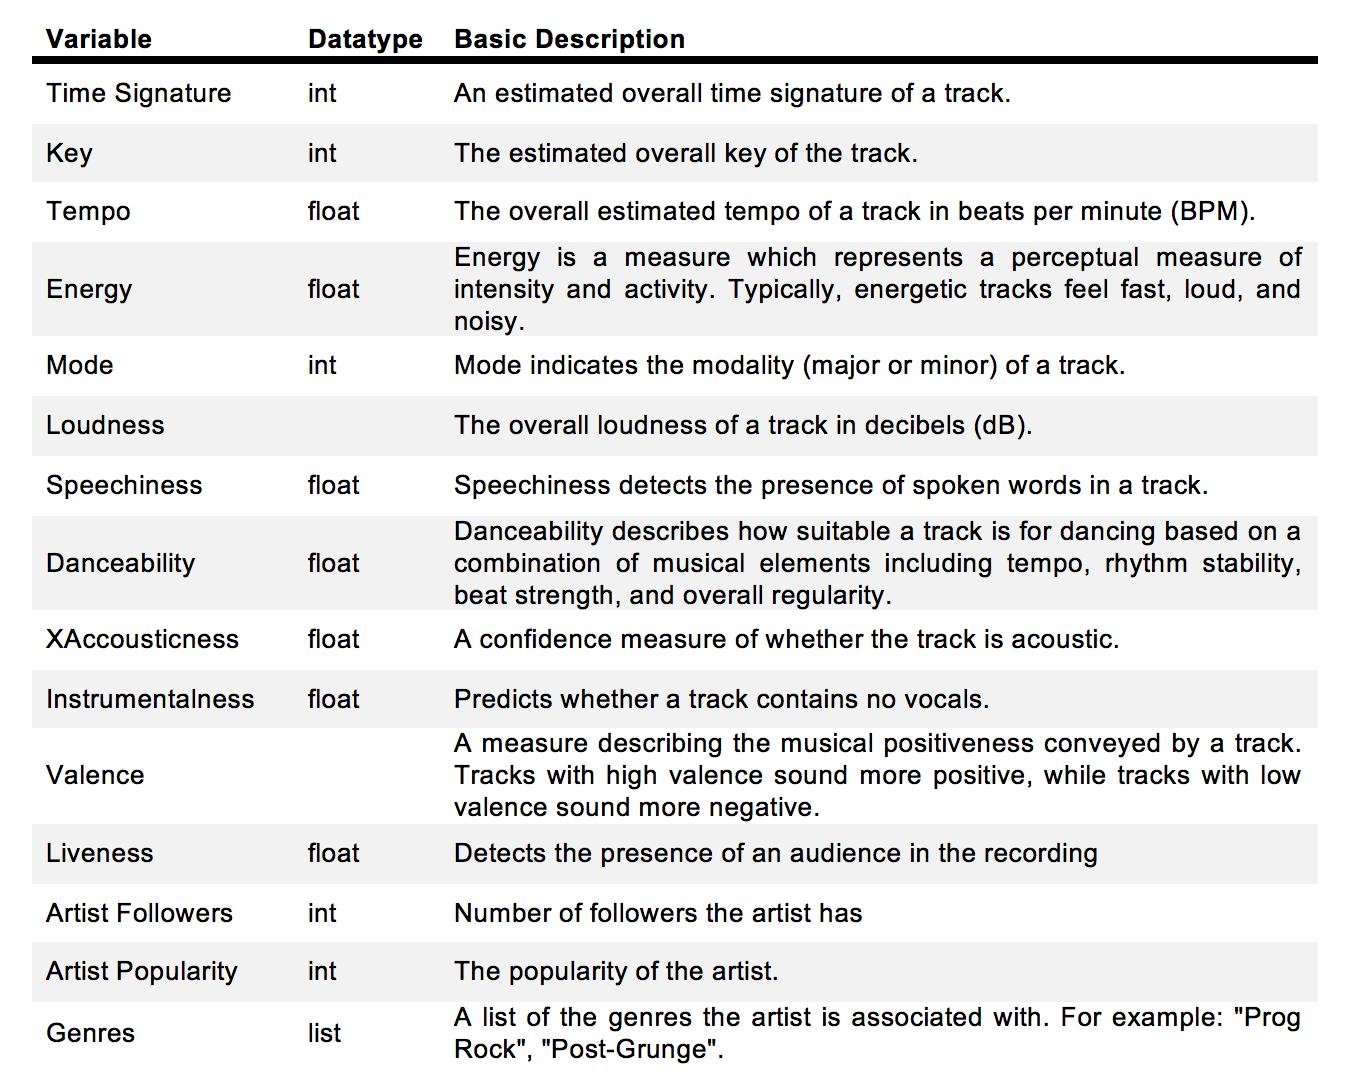

In [47]:
Image("img/eda_table2.png",width=500, height=400)



### Data manipulation and prioritization of variables 
When requesting track data from the API, each song request returns 18 track features. Similarily, when requesting artist data through the API, each request returns 10 features for each artist. Not all of the features returned from the API are useful for our analysis, for example, images from an album are not useful toward predicting a playlist. Therefore, from the 28 possible features that are returned by the Spotify API, we selected 19 to be used for EDA. A few of these 19 variables will not be used for modeling but are needed for tracking purposes. For example, we need to keep track of a song’s unique identifier in order to avoid suggesting that one song be added into a playlist that already contains that one song. Likewise, we may keep track of an artist’s unique identifier in case we want to request songs from a particular artist.

One of the features that we found interesting to explore and understand further is Spotify’s classification of artists into genres. Each artist can be classified as belonging to many genres, for example, an artist can be classified as belonging to a single genre, while another artist can be classified as belonging to 21 genres. Likewise, there are repeated genre classifications under different names, for example, some artists are classified as “k-pop” while others are classified under “Korean pop”; these two are the same.

In order to get around these issues, we decided to classify each song as belonging to only one of five possible macro genres: Rap, Pop, Rock, Pop Rock, and Other.

These categories were chosen upon a qualitative analysis of the genres provided by Spotify API for each song. The classification was done by use of the following logic: 

    •If rap, hiphop, r&b appeared as one of the genres for the song, that song was classified as “Rap”
    •If both the words Rock and Pop appeared as genres for the song (eg: rock, dance rock, pop, dance pop), that song was classified as “Pop Rock”
    •If the word Pop appeared as one of the genres for the song (eg: pop, dance pop), that song was classified as “Pop”
    •If the word Rock appeared as one of the genres for the song (eg: rock, dance rock), that song was classified as “Rock”
    •If none of the keywords defined above showed in the genres of the song, that song was classified as “Other”

After classifying the genres, we created a pandas dataframe of size Nx19 where N is the number of songs obtained and 19 is the number of features for each song in the dataframe. A screenshot of our database is presented below:


In [50]:
def genre_generator(songs_df):

    # Defining genres to single genre
    rap = ["rap","hiphop", "r&d"]

    # finding position of g1 and last position of gX in columns, to use it later for assessingn genre of song

    g1_index = 0 
    last_column_index = 0

    column_names = songs_df.columns.values

    for i in column_names:
        if i == "g1":
            break
        g1_index += 1

    for i in column_names:
        last_column_index += 1

    # loop to create gender for each song in dataframe     

    songs_df["genre"] = "" 

    for j in range(len(songs_df)):

        # Creating list of genres for a given song  
        genres_row = list(songs_df.iloc[[j]][column_names[g1_index:last_column_index-1]].dropna(axis=1).values.flatten())
        # genres_row = ['british invasion', 'merseybeat', 'psychedelic']

        # classifing genre for the song

        genre = "other"

        if any("rock" in s for s in genres_row) and any("pop" in s for s in genres_row):
            genre = "pop rock"
        elif any("rock" in s for s in genres_row):
            genre = "rock"
        elif any("pop" in s for s in genres_row):
            genre = "pop"

        for i in rap:
            if any(i in s for s in genres_row):
                genre = "rap"

        # giving column genre the classified genre for a given song         
        songs_df.set_value(j, 'genre', genre)
    
    return songs_df

In [51]:
songs_df_new = genre_generator(songs_df)

/Users/yalda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


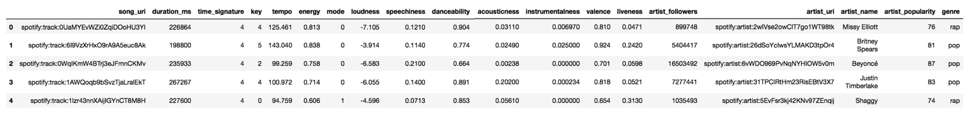

In [52]:
Image("img/eda_pic2.png",width=1000, height=800) 

In [64]:
songs_df_new.head()

song_uri  duration_ms  time_signature  key    tempo  energy  mode  loudness  speechiness  danceability  acousticness  instrumentalness  valence  liveness  artist_followers                             artist_uri        artist_name  artist_popularity         g1       g2             g3    g4       g5    g6    g7                g8                  g9   g10   g11   g12   g13   g14   g15   g16   g17   g18   g19   g20   g21   g22   g23   g24   g25   g26   g27   g28  \
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI       226864               4    4  125.461   0.813     0    -7.105       0.1210         0.904       0.03110          0.006970    0.810    0.0471            908087  spotify:artist:2wIVse2owClT7go1WT98tk      Missy Elliott                 76  dance pop  hip hop        hip pop   pop  pop rap   r&b   rap  southern hip hop  urban contemporary  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak       198800               4    5  143.040   0.838     0    -3.914       0.1140         0.774       0.02490          0.025000    0.924    0.2420           5450023  spotify:artist:26dSoYclwsYLMAKD3tpOr4     Britney Spears                 82  dance pop      pop  post-teen pop  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv       235933               4    2   99.259   0.758     0    -6.583       0.2100         0.664       0.00238          0.000000    0.701    0.0598          16661148  spotify:artist:6vWDO969PvNqNYHIOW5v0m            Beyoncé                 87  dance pop      pop  post-teen pop   r&b     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
3  spotify:track:1AWQoqb9bSvzTjaLralEkT       267267               4    4  100.972   0.714     0    -6.055       0.1400         0.891       0.20200          0.000234    0.818    0.0521           7335491  spotify:artist:31TPClRtHm23RisEBtV3X7  Justin Timberlake                 83  dance pop      pop        pop rap  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   
4  spotify:track:1lzr43nnXAijIGYnCT8M8H       227600               4    0   94.759   0.606     1    -4.596       0.0713         0.853       0.05610          0.000000    0.654    0.3130           1043574  spotify:artist:5EvFsr3kj42KNv97ZEnqij             Shaggy                 74  dance pop  pop rap  reggae fusion  None     None  None  None              None                None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None   

    g29   g30 genre  
0  None  None   rap  
1  None  None   pop  
2  None  None   pop  
3  None  None   rap  
4  None  None   rap

In [54]:
display(songs_df_new['genre'].value_counts())
display(songs_df_new['genre'].value_counts(normalize=True))

rap         19126
pop         14865
other       14699
pop rock     9888
rock         8925
Name: genre, dtype: int64

rap         0.283336
pop         0.220212
other       0.217753
pop rock    0.146482
rock        0.132216
Name: genre, dtype: float64

In [55]:
temp = songs_df_new.copy()
column_names_temp = songs_df_new.columns.values[18:-1]
temp = temp.drop(column_names_temp,axis=1)
feature_indexes = list(range(len(temp.columns)-1))
col_names_temp = ['duration_ms','time_signature','key','tempo','energy','loudness','speechiness','danceability','acousticness',
         'instrumentalness', 'valence', 'liveness', 'artist_followers', 'artist_popularity'  ]



In [56]:
temp.head()

song_uri  duration_ms  time_signature  key    tempo  energy  mode  loudness  speechiness  danceability  acousticness  instrumentalness  valence  liveness  artist_followers                             artist_uri        artist_name  artist_popularity genre
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI       226864               4    4  125.461   0.813     0    -7.105       0.1210         0.904       0.03110          0.006970    0.810    0.0471            908087  spotify:artist:2wIVse2owClT7go1WT98tk      Missy Elliott                 76   rap
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak       198800               4    5  143.040   0.838     0    -3.914       0.1140         0.774       0.02490          0.025000    0.924    0.2420           5450023  spotify:artist:26dSoYclwsYLMAKD3tpOr4     Britney Spears                 82   pop
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv       235933               4    2   99.259   0.758     0    -6.583       0.2100         0.664       0.00238          0.000000    0.701    0.0598          16661148  spotify:artist:6vWDO969PvNqNYHIOW5v0m            Beyoncé                 87   pop
3  spotify:track:1AWQoqb9bSvzTjaLralEkT       267267               4    4  100.972   0.714     0    -6.055       0.1400         0.891       0.20200          0.000234    0.818    0.0521           7335491  spotify:artist:31TPClRtHm23RisEBtV3X7  Justin Timberlake                 83   rap
4  spotify:track:1lzr43nnXAijIGYnCT8M8H       227600               4    0   94.759   0.606     1    -4.596       0.0713         0.853       0.05610          0.000000    0.654    0.3130           1043574  spotify:artist:5EvFsr3kj42KNv97ZEnqij             Shaggy                 74   rap

Finally, in order to deal with categorical variables, we used one-hot encoding techniques. For example, our categorization of genre had to be one-hot encoded in order to be able to utilize that variable for analysis.

## Visualizations of EDA

Once data was gathered and cleaned for analysis, we proceeded into doing some data visualization and actual exploration.

### Variable correlations
We first generated a scatter matrix to get a quick understanding of the data. We found that there are a few correlations among variables (regardless of classes). For instance, energy (5th feature) seems to be positively correlated with loudness (7th feature), and negatively correlated with accousticness (10th feature). This gives us a hint that the predictive power of each of these pairs might change when these variables are considered together in our models. 

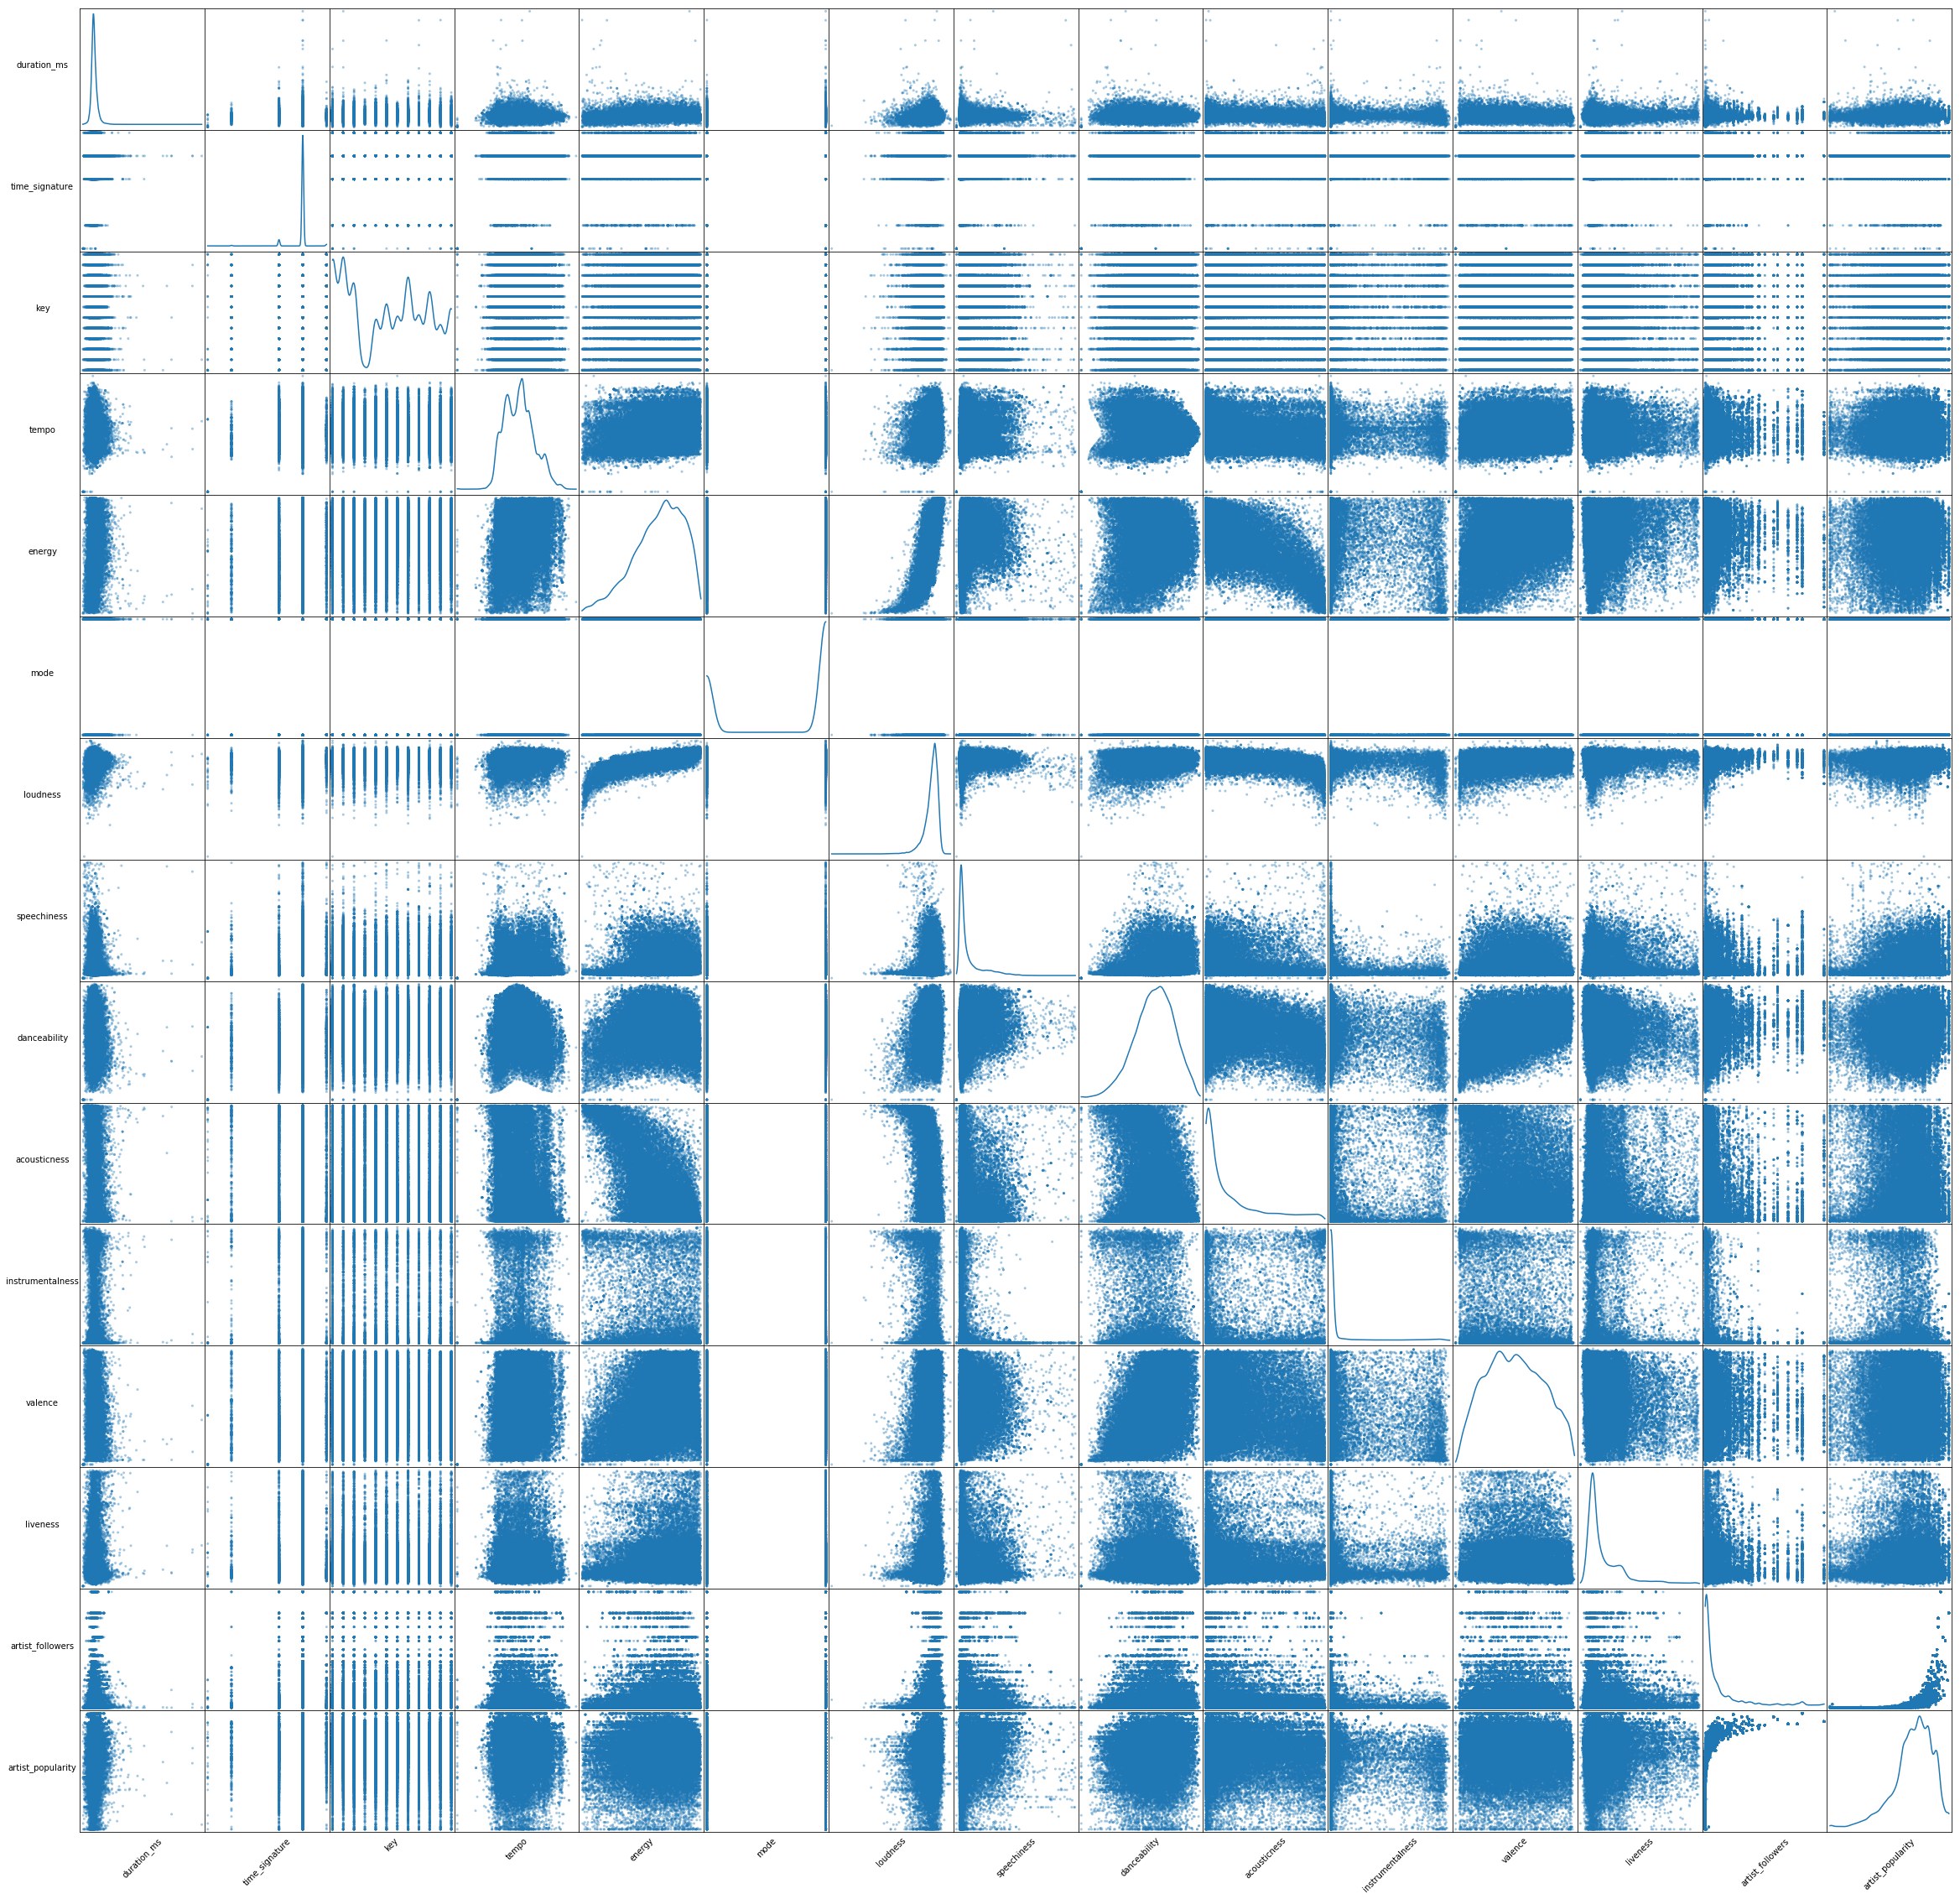

In [57]:
### this code goes after @1
from pandas.plotting import scatter_matrix
smplot = scatter_matrix(temp, alpha=0.4, figsize=(40, 40), diagonal='kde')

[s.xaxis.label.set_rotation(45) for s in smplot.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in smplot.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in smplot.reshape(-1)]

[s.set_xticks(()) for s in smplot.reshape(-1)]
[s.set_yticks(()) for s in smplot.reshape(-1)]

plt.savefig('scatter_matrix.png')
plt.show()

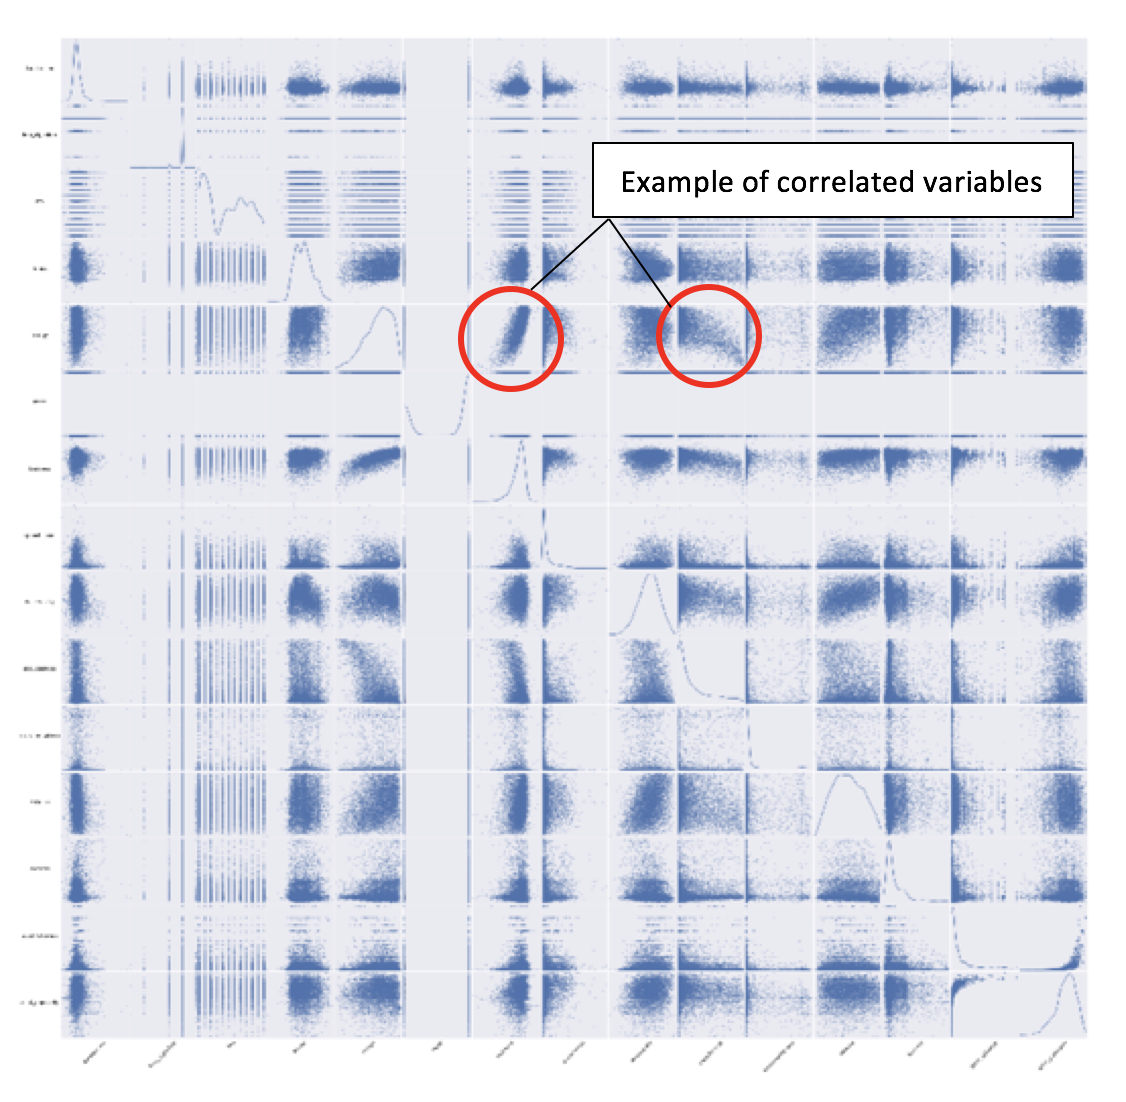

In [58]:
Image("img/eda_pic3.png",width=500, height=400)


### Noteworthy findings

After creating a scatter matrix of the variables, we decided to look at the distribution of the variables over 1000 songs. Appendix 2 contains distribution plots for each of the song features. This step was not very informative, but of some interest was the following few distributions: 

Artist followers – most artists have few followers, but there are a few artists that have a large number of followers.

In [62]:
### this goes after @2
def plot_dist_features(df, features, save=False, path=str):
    
    """
    Plots the distribution of all features passed into the function and saves them
    if save == True.
    
    Arguments:
        - df: the dataframe used to plot features
        - features: the column names of the dataframe whose features are to be plot
        - save: boolean indicating whether the plots are to be saved
        - path: string indicating the path of where to save the features.
    
    Return: None, just prints the distributions
    """
    
    for i in features:
        fig, axs = plt.subplots(1, figsize=(9,6))
        sns.set(style='white', palette='deep')
        
        x = df[i]
        if i == 'duration_ms':
            x = x/1000
            sns.kdeplot(x, label = 'duration in seconds', shade=True).set_title("Distribution of Feature Duration")
        else:
            sns.kdeplot(x, label = i, shade=True).set_title("Distribution of Feature "+i)
        
        if save:
            filename='distribution_plot_'+i
            fig.savefig(path+filename)
    
    return

features_2_plot = set(list(temp.columns.values[0:18]))^set(['song_uri','artist_uri','artist_name'])
path = '/Users/danny_barjum/Dropbox/DS Project/05 - code/01 - EDA/fig/dists/'
#plot_dist_features(temp, features_2_plot, save=True, path=path)

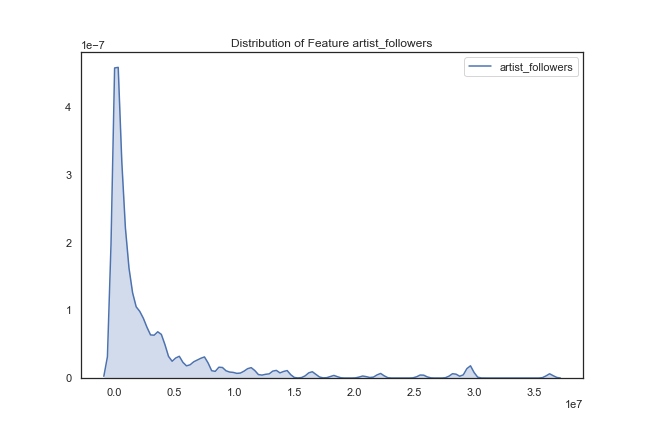

In [59]:
Image("img/distribution_plot_artist_followers.png",width=500, height=400)

Instrumentalness – this distribution shows that most songs have vocals (close to 0), but there are quite a few songs with no vocals (close to 1).

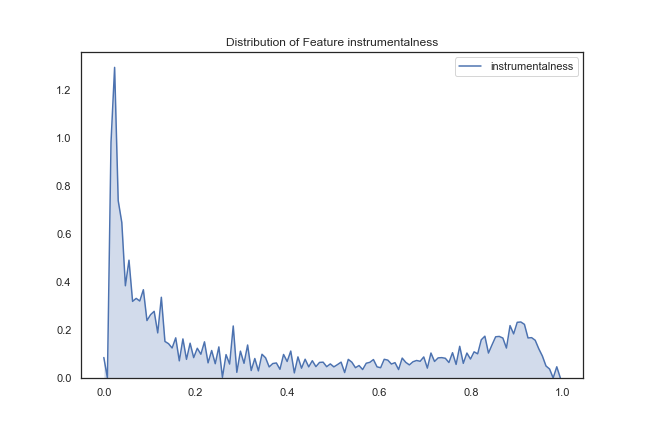

In [60]:
Image("img/distribution_plot_instrumentalness.png",width=500, height=400)

Song Duration – this was just placed out of curiosity that the vast majority of songs seem to last around 250 seconds (about 4 minutes).

![png](img/distribution_plot_duration_ms.png)

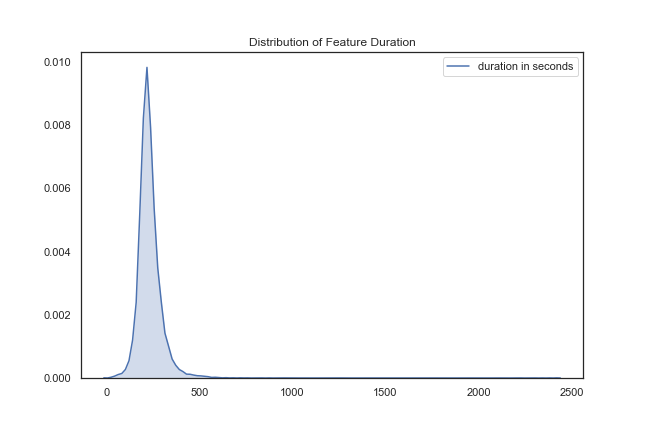

In [61]:
Image("img/distribution_plot_duration_ms.png",width=500, height=400)

We then decided to group songs by genre and look at the distribution of songs that fall under the five genres we created. The distribution of 1000 songs were as follows:
 
    rap         27.2 %
    pop         22.7 %
    other       21.6 %
    pop rock    14.9 %
    rock        13.6 %

It appears that the most commonly occurring genre is rap, followed by pop.

We then looked at how each feature is distributed when grouped by genre (see appendix 1). A few findings of interest were danceability, energy and artist popularity (shown below). These seem like variables that we could use to discriminate between the genres.



In [69]:
col_names = temp.columns
#fig, axs = plt.subplots(14)
#fig.set_size_inches(20, 120)
#sns.set(style='white', palette='deep',font_scale=1.5)
#for i in range(len(col_names_temp)):
#    sns.distplot(temp.loc[temp['genre']=='pop'][col_names_temp[i]].values,kde_kws={"label": "pop"},ax = axs[i]).set_title(col_names_temp[i])#,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')
#    sns.distplot(temp.loc[temp['genre']=='rock'][col_names_temp[i]].values,kde_kws={"label": "rock"},ax = axs[i]).set_title(col_names_temp[i]) #,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')
#    sns.distplot(temp.loc[temp['genre']=='rap'][col_names_temp[i]].values,kde_kws={"label": "rap"},ax = axs[i]).set_title(col_names_temp[i]) #,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')
#    sns.distplot(temp.loc[temp['genre']=='pop rock'][col_names_temp[i]].values,kde_kws={"label": "pop rock"},ax = axs[i]).set_title(col_names_temp[i]) #,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')
#    sns.distplot(temp.loc[temp['genre']=='other'][col_names_temp[i]].values,kde_kws={"label": "other"},ax = axs[i]).set_title(col_names_temp[i]) #,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')

# fig.savefig('feature_hist.png')


In [26]:
songs_encoded = pd.get_dummies(temp,columns = ['genre'],drop_first=True)
songs_encoded .head()

#### the correlation code would goes after this  @1

song_uri  duration_ms  time_signature  key    tempo  energy  mode  loudness  speechiness  danceability  acousticness  instrumentalness  valence  liveness  artist_followers                             artist_uri        artist_name  artist_popularity  genre_pop  genre_pop rock  genre_rap  genre_rock
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI       226864               4    4  125.461   0.813     0    -7.105       0.1210         0.904       0.03110          0.006970    0.810    0.0471            900226  spotify:artist:2wIVse2owClT7go1WT98tk      Missy Elliott                 76          0               0          1           0
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak       198800               4    5  143.040   0.838     0    -3.914       0.1140         0.774       0.02490          0.025000    0.924    0.2420           5407311  spotify:artist:26dSoYclwsYLMAKD3tpOr4     Britney Spears                 81          1               0          0           0
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv       235933               4    2   99.259   0.758     0    -6.583       0.2100         0.664       0.00238          0.000000    0.701    0.0598          16514236  spotify:artist:6vWDO969PvNqNYHIOW5v0m            Beyoncé                 87          1               0          0           0
3  spotify:track:1AWQoqb9bSvzTjaLralEkT       267267               4    4  100.972   0.714     0    -6.055       0.1400         0.891       0.20200          0.000234    0.818    0.0521           7281071  spotify:artist:31TPClRtHm23RisEBtV3X7  Justin Timberlake                 83          1               0          0           0
4  spotify:track:1lzr43nnXAijIGYnCT8M8H       227600               4    0   94.759   0.606     1    -4.596       0.0713         0.853       0.05610          0.000000    0.654    0.3130           1036043  spotify:artist:5EvFsr3kj42KNv97ZEnqij             Shaggy                 74          0               0          1           0


The Final step of our EDA consisted into looking at boxplots of each feature grouped by genre. The purpose of this was to also see if some variables stand out as being useful for prediction. The results of this analysis are shown in appendix 3. From this analysis we discovered that a few informative variables are Speechness, Danceability, Log of instrumentalness, Artist followers, and Artist popularity:


In [72]:
# for i in range(len(col_names_temp)):
#     fig, axs = plt.subplots(1)
#     fig.set_size_inches(16, 10)
#     sns.set(font_scale=1.5,style='white', palette='deep') 
#     axs.set_yscale("log")
#     sns.boxplot(x = temp['genre'] , y=temp[col_names_temp[i]].values,palette='pastel').set_title(col_names_temp[i]) 
#     fig.savefig('feature_box_{}.png'.format(i))




In [ ]:

fig, axs = plt.subplots(14)
fig.set_size_inches(20, 120)
sns.set(font_scale=1.5,style='white', palette='deep') 
for i in range(len(col_names_temp)):
    sns.violinplot(x = temp['genre'] , y=temp[col_names_temp[i]].values,ax = axs[i],showfliers=False).set_title(col_names_temp[i])#,hue=casual_mean_w.iloc[0:,1] ,data=casual_mean_w, style =casual_mean_w.iloc[0:,1] , markers=True, dashes=False,ax=ax1).set_title('how each weather category affects number of casual riders in different hour of a day')
fig.savefig('feature_violin.png')



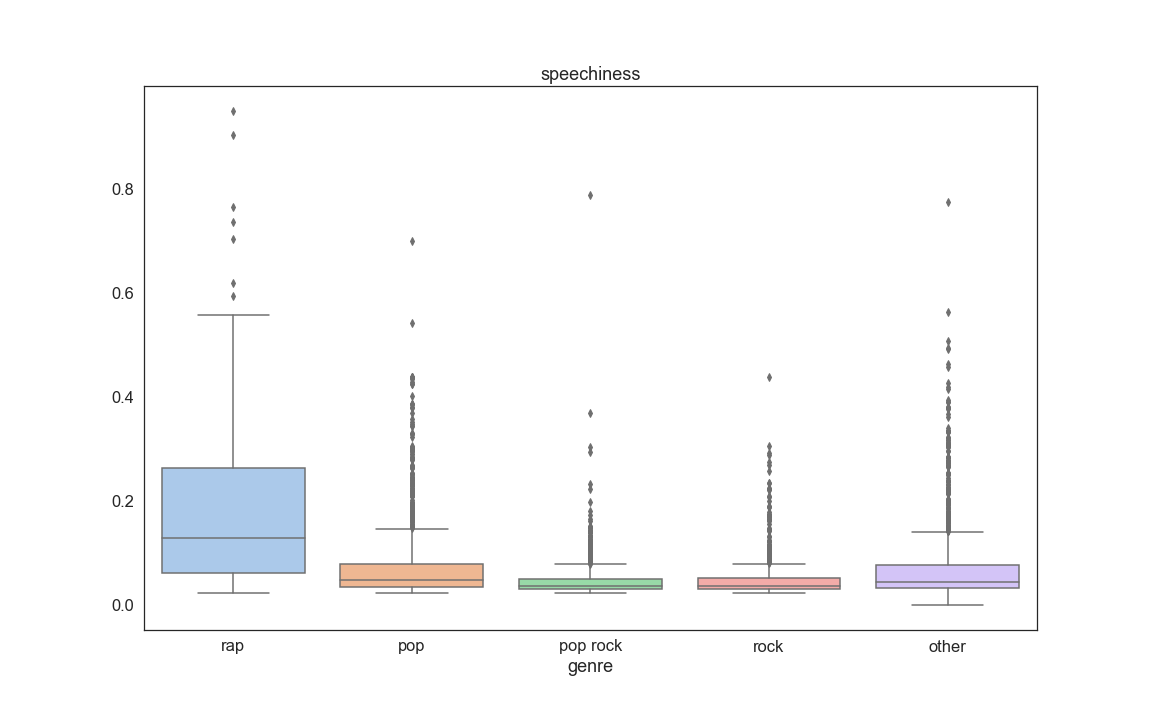

In [40]:
Image("img/feature_violin_6_speechness.png",width=500, height=400)

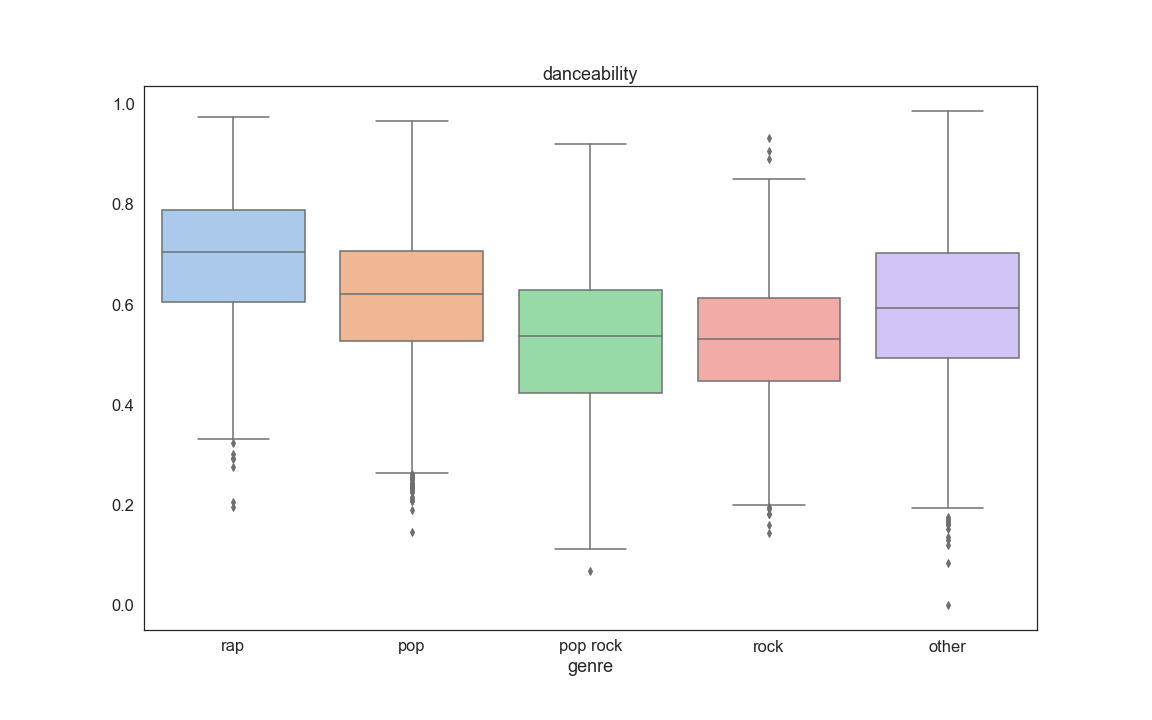

In [41]:
Image("img/feature_violin_7_danceability.png",width=500, height=400)

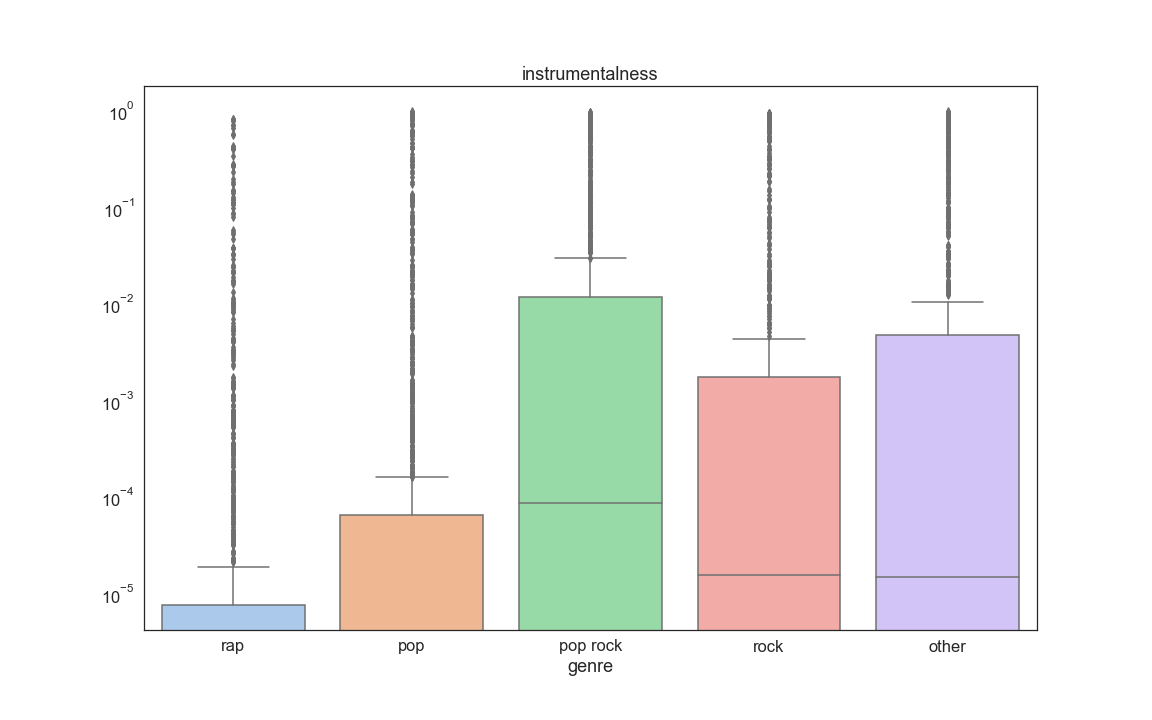

In [42]:
Image("img/feature_violin_9_instrumentalness_log.png",width=500, height=400)

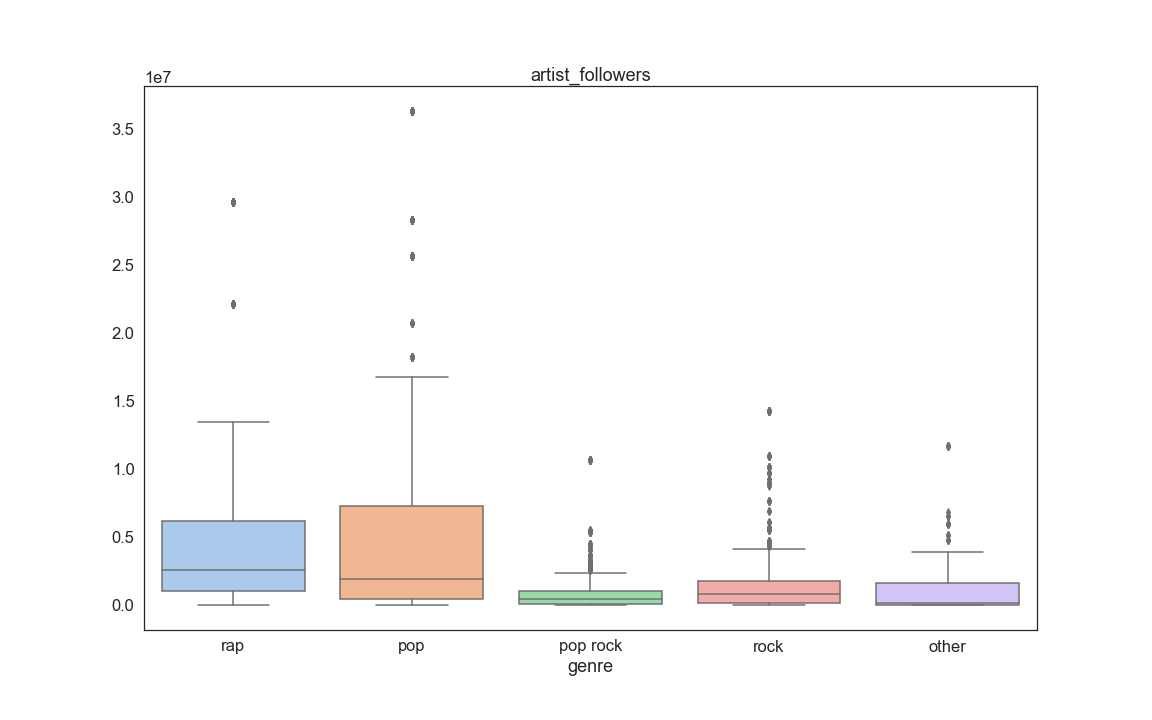

In [43]:
Image("img/feature_violin_12_artistfollowers.png",width=500, height=400)

In [73]:
# fig, axs = plt.subplots(14)
# fig.set_size_inches(20, 120)
# sns.set(font_scale=1.5,style='white', palette='deep') 
# for i in range(len(col_names_temp)):
#     sns.boxplot(x = temp['genre'] , y=temp[col_names_temp[i]].values,ax = axs[i],showfliers=0).set_title(col_names_temp[i]) 
# #    fig.savefig('feature_violin_{}.png'.format(i))
# fig.savefig('feature_boxplot.png')

# ### @2